In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

Load Preprocessed Data and Embeddings

In [23]:
# Load the dataset
data = pd.read_csv("spam_or_not_spam.csv")
data = data.dropna(subset=['email'])
data['email'] = data['email'].astype(str)

# Preprocess the data
def preprocess_text(text):
    """
    Preprocesses the input text by removing numbers, special characters, and converting to lowercase.
    """
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = text.lower()  # Convert to lowercase
    return text

data['cleaned_email'] = data['email'].apply(preprocess_text)
data['tokens'] = data['cleaned_email'].apply(lambda x: x.split())

# Load the word embeddings
word_embeddings = np.load("wordEmbeddings.npy")  # Ensure this file exists in the same directory
vocab_size, EMBEDDING_DIM = word_embeddings.shape

# Build the vocabulary mapping
corpus = data['tokens'].tolist()
word_counts = Counter([word for sentence in corpus for word in sentence])
vocab = list(word_counts.keys())
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

print("Data preprocessing and vocabulary setup completed.")


Data preprocessing and vocabulary setup completed.


Prepare Data for Neural Network

In [24]:
# Define sequence length
SEQUENCE_LENGTH = 12  # Emails will be represented by 12 words

# Function to pad or truncate sequences
def pad_or_truncate(tokens, sequence_length):
    """
    Pads or truncates token lists to a fixed length.
    """
    tokens = tokens[:sequence_length]
    if len(tokens) < sequence_length:
        tokens += ['<PAD>'] * (sequence_length - len(tokens))
    return tokens

# Add a special token for padding if not already present
if '<PAD>' not in word_to_index:
    word_to_index['<PAD>'] = len(word_to_index)  # Assign the next available index to <PAD>

# Check for tokens in word_to_index that are missing in word_embeddings
missing_tokens = len(word_to_index) - word_embeddings.shape[0]

# Add zero vectors to word_embeddings for missing tokens
if missing_tokens > 0:
    extra_rows = np.zeros((missing_tokens, EMBEDDING_DIM))
    word_embeddings = np.vstack([word_embeddings, extra_rows])

# Validate that word_to_index and word_embeddings are now aligned
assert len(word_to_index) == word_embeddings.shape[0], (
    f"Mismatch detected: word_to_index size ({len(word_to_index)}) != word_embeddings size ({word_embeddings.shape[0]})"
)

# Convert tokens to sequences of indices
data['sequence'] = data['tokens'].apply(
    lambda x: [word_to_index.get(word, word_to_index['<PAD>']) for word in pad_or_truncate(x, SEQUENCE_LENGTH)]
)

# Prepare input features (X) and labels (y)
X = np.array([
    np.concatenate([word_embeddings[idx] for idx in seq])  # Convert each index to its corresponding embedding
    for seq in data['sequence']
])
y = data['label'].values

# Print the resulting shapes for validation
print(f"Input shape: {X.shape}, Output shape: {y.shape}")


Input shape: (2999, 120), Output shape: (2999,)


Define Neural Network Structure

In [25]:
# Network architecture
INPUT_SIZE = SEQUENCE_LENGTH * EMBEDDING_DIM  # 12 words * 10 dimensions = 120
HIDDEN_SIZE_1 = 8
HIDDEN_SIZE_2 = 2
OUTPUT_SIZE = 1

# Initialize weights
np.random.seed(42)
W1 = np.random.uniform(-1, 1, (INPUT_SIZE, HIDDEN_SIZE_1))
W2 = np.random.uniform(-1, 1, (HIDDEN_SIZE_1, HIDDEN_SIZE_2))
W3 = np.random.uniform(-1, 1, (HIDDEN_SIZE_2, OUTPUT_SIZE))

Define Activation Functions and Their Derivatives

In [26]:
def relu(x):
    """
    Applies the ReLU activation function.
    """
    return np.maximum(0, x)

def relu_derivative(x):
    """
    Computes the derivative of ReLU activation function.
    """
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    """
    Applies the sigmoid activation function.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    Computes the derivative of sigmoid activation function.
    """
    s = sigmoid(x)
    return s * (1 - s)

Train the Neural Network

In [27]:
# Training parameters
LEARNING_RATE = 0.001
EPOCHS = 10

# Training loop
for epoch in range(EPOCHS):
    total_loss = 0
    for i in range(len(X)):
        # Forward pass
        x = X[i].reshape(1, -1)
        y_true = y[i]
        
        z1 = np.dot(x, W1)
        a1 = relu(z1)
        
        z2 = np.dot(a1, W2)
        a2 = relu(z2)
        
        z3 = np.dot(a2, W3)
        y_pred = sigmoid(z3)
        
        # Compute loss (binary cross-entropy)
        loss = - (y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
        total_loss += loss.item()
        
        # Backward pass
        dz3 = y_pred - y_true  # Derivative of loss w.r.t z3
        dW3 = np.dot(a2.T, dz3)
        
        dz2 = np.dot(dz3, W3.T) * relu_derivative(z2)
        dW2 = np.dot(a1.T, dz2)
        
        dz1 = np.dot(dz2, W2.T) * relu_derivative(z1)
        dW1 = np.dot(x.T, dz1)
        
        # Update weights
        W3 -= LEARNING_RATE * dW3
        W2 -= LEARNING_RATE * dW2
        W1 -= LEARNING_RATE * dW1
    
    avg_loss = total_loss / len(X)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")

Epoch 1/10, Average Loss: 0.2110
Epoch 2/10, Average Loss: 0.4620
Epoch 3/10, Average Loss: 0.3900
Epoch 4/10, Average Loss: 0.3401
Epoch 5/10, Average Loss: 0.3433
Epoch 6/10, Average Loss: 0.3489
Epoch 7/10, Average Loss: 0.3466
Epoch 8/10, Average Loss: 0.3463
Epoch 9/10, Average Loss: 0.3425
Epoch 10/10, Average Loss: 0.3430


Evaluate the Model

In [28]:
# Forward pass for all samples
def forward_pass(X):
    z1 = np.dot(X, W1)
    a1 = relu(z1)
    z2 = np.dot(a1, W2)
    a2 = relu(z2)
    z3 = np.dot(a2, W3)
    y_pred = sigmoid(z3)
    return y_pred

# Get predictions
y_probs = forward_pass(X).flatten()
y_pred = (y_probs >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.20
Precision: 0.17
Recall: 0.95
F1 Score: 0.28


Visualize the Confusion Matrix

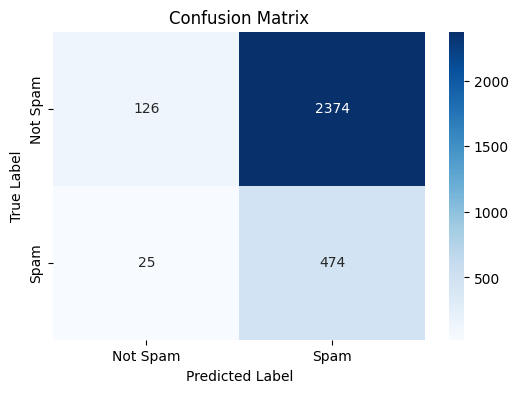

In [29]:
# Generate confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()